In [1]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import keras
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import *
from keras.models import Sequential, Model, load_model
from tensorflow.keras import mixed_precision
import keras.backend as K
import pandas as pd
from tensorflow.keras import mixed_precision
import matplotlib.pyplot as plt
import splitfolders
import zipfile
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, LearningRateScheduler
import shutil
import sys
from sklearn.metrics import classification_report, accuracy_score

ModuleNotFoundError: No module named 'numpy'

In [2]:
!pip install numpy

   ---------------------------------------- 0.0/15.9 MB ? eta -:--:--
   - -------------------------------------- 0.5/15.9 MB 2.8 MB/s eta 0:00:06
   --- ------------------------------------ 1.6/15.9 MB 4.4 MB/s eta 0:00:04
   -------- ------------------------------- 3.4/15.9 MB 6.3 MB/s eta 0:00:02
   ------------ --------------------------- 5.0/15.9 MB 6.6 MB/s eta 0:00:02
   --------------- ------------------------ 6.3/15.9 MB 6.7 MB/s eta 0:00:02
   -------------------- ------------------- 8.1/15.9 MB 7.2 MB/s eta 0:00:02
   ------------------------- -------------- 10.2/15.9 MB 7.5 MB/s eta 0:00:01
   ------------------------------ --------- 12.1/15.9 MB 7.7 MB/s eta 0:00:01
   ---------------------------------- ----- 13.9/15.9 MB 7.9 MB/s eta 0:00:01
   ---------------------------------------  15.7/15.9 MB 8.0 MB/s eta 0:00:01
   ---------------------------------------- 15.9/15.9 MB 7.4 MB/s eta 0:00:00


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorboard 2.10.1 requires google-auth<3,>=1.6.3, which is not installed.
tensorboard 2.10.1 requires grpcio>=1.24.3, which is not installed.
tensorboard 2.10.1 requires markdown>=2.6.8, which is not installed.
tensorboard 2.10.1 requires protobuf<3.20,>=3.9.2, which is not installed.
tensorboard 2.10.1 requires werkzeug>=1.0.1, which is not installed.
tensorflow-gpu 2.10.0 requires grpcio<2.0,>=1.24.3, which is not installed.
tensorflow-gpu 2.10.0 requires h5py>=2.9.0, which is not installed.
tensorflow-gpu 2.10.0 requires protobuf<3.20,>=3.9.2, which is not installed.
tensorflow-gpu 2.10.0 requires wrapt>=1.11.0, which is not installed.


In [13]:
print(sys.version)

3.9.16 (main, Mar  8 2023, 10:39:24) [MSC v.1916 64 bit (AMD64)]


In [14]:
tf. __version__

'2.10.0'

In [15]:
keras.__version__

'2.10.0'

In [16]:
os.listdir('./White_blood_cell_classification_dataset')

['TestA', 'Train']

In [17]:
# 80% Train 20% Val 
splitfolders.ratio("./White_blood_cell_classification_dataset./train", output="split",
    seed=1337, ratio=(.8, .2,), group_prefix=None, move=False) # default values

In [127]:
epochs = 50 # Total epochs to run
hw = 256 # Height/Width of images
batch_size = 64

In [128]:
from keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest',
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        './split/train/',
        target_size=(hw, hw),
        class_mode='sparse',
        shuffle=True,
        batch_size=batch_size
)

val_generator = val_datagen.flow_from_directory(
        './split/val/',
        target_size=(hw, hw),
        class_mode='sparse',
        batch_size=batch_size
)

test_generator = test_datagen.flow_from_directory(
        './White_blood_cell_classification_dataset/TestA',
        target_size=(hw, hw),
        class_mode='sparse',
        batch_size=batch_size,
        shuffle=False
)


Found 8137 images belonging to 5 classes.
Found 2038 images belonging to 5 classes.
Found 4339 images belonging to 5 classes.


In [129]:
def conv_block(x, f, k):
    conv = Conv2D(f, k, strides=1, padding='same')(x)
    conv = BatchNormalization()(conv)
    conv = Activation('swish')(conv)
    return conv


def squeeze_excite_block(tensor):
    # Codes used from : https://github.com/titu1994/keras-squeeze-excite-network
    init = tensor
    filters = init.shape[-1]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // 2, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)


    x = multiply([init, se])
    return x

def fused_mbconv(x, f=8):
    conv = conv_block(x, f, 3)
    conv = squeeze_excite_block(conv)
    identity = conv_block(x, f, 1)
    return Add()([conv, identity])

def dw_conv(x, k=3):
    conv = DepthwiseConv2D(k, strides=1, padding='same')(x)
    conv = BatchNormalization()(conv)
    conv = Activation('swish')(conv)
    return conv


def inverted_residual_block(x, squeeze, expand):
    conv = Conv2D(expand, 1, strides=1, padding='same')(x)
    conv = BatchNormalization()(conv)
    conv = Activation('swish')(conv)
    
    conv = DepthwiseConv2D(3, strides=1, padding='same')(conv)
    conv = BatchNormalization()(conv)
    conv = Activation('swish')(conv)
    
    conv = Conv2D(squeeze, 1, strides=1, padding='same')(conv)
    conv = BatchNormalization()(conv)
    conv = Activation('swish')(conv)
    
    return Add()([conv, x])


def get_output(x, output_name):
   
    squeeze = 6
    expand = 12
    
    conv = inverted_residual_block(x, squeeze, expand)
    conv = inverted_residual_block(conv, squeeze, expand)
    conv = MaxPooling2D(pool_size=(2))(conv)
    
    conv = conv_block(conv, squeeze*2, 1)

    conv = inverted_residual_block(conv, squeeze*2, expand*3)
    conv = inverted_residual_block(conv, squeeze*2, expand*3)
    conv = inverted_residual_block(conv, squeeze*2, expand*3)
    conv = inverted_residual_block(conv, squeeze*2, expand*3)
    conv = MaxPooling2D(pool_size=(2))(conv)
    
    conv = conv_block(conv, squeeze*2, 1)
    
    conv = inverted_residual_block(conv, squeeze*2, expand*4)
    conv = inverted_residual_block(conv, squeeze*2, expand*4)
    conv = inverted_residual_block(conv, squeeze*2, expand*4)
    conv = inverted_residual_block(conv, squeeze*2, expand*4)
    
    
    conv = conv_block(conv, expand*7, 1)
    
    f1 = GlobalAveragePooling2D()(conv)
    
    d1 = Dense(38, activation='swish', name=output_name)(f1)
    
    return d1


def L100KV2_NET():

    f = 6
    x = Input(shape=(hw,hw,3,))
    
    
    init = x
    conv = Conv2D(f, 7, strides=3, padding='same')(init)
    conv = Activation('swish')(conv)
    
    conv = MaxPooling2D(2)(conv)
    
    conv_1 = fused_mbconv(conv, f=f)
    op1 = get_output(conv_1, 'output_1')
    
    conv_2 = fused_mbconv(conv_1, f=f)
    op2 = get_output(conv_2, 'output_2')
    
    conv_3 = fused_mbconv(concatenate([conv_1, conv_2]), f=f)
    op3 = get_output(conv_3, 'output_3')
    
    conv_4 = fused_mbconv(concatenate([conv_1, conv_2, conv_3]), f=f)
    op4 = get_output(conv_4, 'output_4')
    
    conv_5 = fused_mbconv(concatenate([conv_1, conv_2, conv_3, conv_4]), f=f)
    op5 = get_output(conv_5, 'output_5')

    

    model = Model(inputs=x, outputs=[op1, op2, op3, op4, op5])
    
    return model

model = L100KV2_NET()
model.summary()

Model: "model_89"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_95 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_12728 (Conv2D)          (None, 86, 86, 6)    888         ['input_95[0][0]']               
                                                                                                  
 activation_17618 (Activation)  (None, 86, 86, 6)    0           ['conv2d_12728[0][0]']           
                                                                                                  
 max_pooling2d_1406 (MaxPooling  (None, 43, 43, 6)   0           ['activation_17618[0][0]']

 chNormalization)                                                                                 
                                                                                                  
 activation_17689 (Activation)  (None, 43, 43, 6)    0           ['batch_normalization_17594[0][0]
                                                                 ']                               
                                                                                                  
 global_average_pooling2d_900 (  (None, 6)           0           ['activation_17689[0][0]']       
 GlobalAveragePooling2D)                                                                          
                                                                                                  
 reshape_452 (Reshape)          (None, 1, 1, 6)      0           ['global_average_pooling2d_900[0]
                                                                 [0]']                            
          

                                                                                                  
 dense_908 (Dense)              (None, 1, 1, 3)      21          ['reshape_454[0][0]']            
                                                                                                  
 conv2d_12830 (Conv2D)          (None, 43, 43, 6)    150         ['concatenate_269[0][0]']        
                                                                                                  
 dense_909 (Dense)              (None, 1, 1, 6)      24          ['dense_908[0][0]']              
                                                                                                  
 batch_normalization_17665 (Bat  (None, 43, 43, 6)   24          ['conv2d_12830[0][0]']           
 chNormalization)                                                                                 
                                                                                                  
 multiply_

 batch_normalization_17632 (Bat  (None, 43, 43, 12)  48          ['depthwise_conv2d_4920[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_17667 (Bat  (None, 43, 43, 12)  48          ['depthwise_conv2d_4930[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 activation_17622 (Activation)  (None, 43, 43, 12)   0           ['batch_normalization_17527[0][0]
                                                                 ']                               
                                                                                                  
 activation_17657 (Activation)  (None, 43, 43, 12)   0           ['batch_normalization_17562[0][0]
          

                                                                                                  
 conv2d_12833 (Conv2D)          (None, 43, 43, 12)   84          ['add_5385[0][0]']               
                                                                                                  
 batch_normalization_17529 (Bat  (None, 43, 43, 12)  48          ['conv2d_12733[0][0]']           
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_17564 (Bat  (None, 43, 43, 12)  48          ['conv2d_12758[0][0]']           
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_17599 (Bat  (None, 43, 43, 12)  48          ['conv2d_12783[0][0]']           
 chNormali

                                                                                                  
 conv2d_12809 (Conv2D)          (None, 43, 43, 6)    78          ['activation_17730[0][0]']       
                                                                                                  
 conv2d_12834 (Conv2D)          (None, 43, 43, 6)    78          ['activation_17765[0][0]']       
                                                                                                  
 batch_normalization_17531 (Bat  (None, 43, 43, 6)   24          ['conv2d_12734[0][0]']           
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_17566 (Bat  (None, 43, 43, 6)   24          ['conv2d_12759[0][0]']           
 chNormalization)                                                                                 
          

                                                                                                  
 batch_normalization_17637 (Bat  (None, 21, 21, 12)  48          ['conv2d_12810[0][0]']           
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_17672 (Bat  (None, 21, 21, 12)  48          ['conv2d_12835[0][0]']           
 chNormalization)                                                                                 
                                                                                                  
 activation_17627 (Activation)  (None, 21, 21, 12)   0           ['batch_normalization_17532[0][0]
                                                                 ']                               
                                                                                                  
 activatio

 batch_normalization_17604 (Bat  (None, 21, 21, 36)  144         ['depthwise_conv2d_4912[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_17639 (Bat  (None, 21, 21, 36)  144         ['depthwise_conv2d_4922[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_17674 (Bat  (None, 21, 21, 36)  144         ['depthwise_conv2d_4932[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 activation_17629 (Activation)  (None, 21, 21, 36)   0           ['batch_normalization_17534[0][0]
          

 conv2d_12788 (Conv2D)          (None, 21, 21, 36)   468         ['add_5365[0][0]']               
                                                                                                  
 conv2d_12813 (Conv2D)          (None, 21, 21, 36)   468         ['add_5376[0][0]']               
                                                                                                  
 conv2d_12838 (Conv2D)          (None, 21, 21, 36)   468         ['add_5387[0][0]']               
                                                                                                  
 batch_normalization_17536 (Bat  (None, 21, 21, 36)  144         ['conv2d_12738[0][0]']           
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_17571 (Bat  (None, 21, 21, 36)  144         ['conv2d_12763[0][0]']           
 chNormali

 conv2d_12764 (Conv2D)          (None, 21, 21, 12)   444         ['activation_17667[0][0]']       
                                                                                                  
 conv2d_12789 (Conv2D)          (None, 21, 21, 12)   444         ['activation_17702[0][0]']       
                                                                                                  
 conv2d_12814 (Conv2D)          (None, 21, 21, 12)   444         ['activation_17737[0][0]']       
                                                                                                  
 conv2d_12839 (Conv2D)          (None, 21, 21, 12)   444         ['activation_17772[0][0]']       
                                                                                                  
 batch_normalization_17538 (Bat  (None, 21, 21, 12)  48          ['conv2d_12739[0][0]']           
 chNormalization)                                                                                 
          

                                                                                                  
 activation_17704 (Activation)  (None, 21, 21, 36)   0           ['batch_normalization_17609[0][0]
                                                                 ']                               
                                                                                                  
 activation_17739 (Activation)  (None, 21, 21, 36)   0           ['batch_normalization_17644[0][0]
                                                                 ']                               
                                                                                                  
 activation_17774 (Activation)  (None, 21, 21, 36)   0           ['batch_normalization_17679[0][0]
                                                                 ']                               
                                                                                                  
 depthwise

 activation_17671 (Activation)  (None, 21, 21, 12)   0           ['batch_normalization_17576[0][0]
                                                                 ']                               
                                                                                                  
 activation_17706 (Activation)  (None, 21, 21, 12)   0           ['batch_normalization_17611[0][0]
                                                                 ']                               
                                                                                                  
 activation_17741 (Activation)  (None, 21, 21, 12)   0           ['batch_normalization_17646[0][0]
                                                                 ']                               
                                                                                                  
 activation_17776 (Activation)  (None, 21, 21, 12)   0           ['batch_normalization_17681[0][0]
          

 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_17578 (Bat  (None, 21, 21, 36)  144         ['depthwise_conv2d_4905[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_17613 (Bat  (None, 21, 21, 36)  144         ['depthwise_conv2d_4915[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_17648 (Bat  (None, 21, 21, 36)  144         ['depthwise_conv2d_4925[0][0]']  
 chNormalization)                                                                                 
          

                                                                                                  
 max_pooling2d_1408 (MaxPooling  (None, 10, 10, 12)  0           ['add_5346[0][0]']               
 2D)                                                                                              
                                                                                                  
 max_pooling2d_1410 (MaxPooling  (None, 10, 10, 12)  0           ['add_5357[0][0]']               
 2D)                                                                                              
                                                                                                  
 max_pooling2d_1412 (MaxPooling  (None, 10, 10, 12)  0           ['add_5368[0][0]']               
 2D)                                                                                              
                                                                                                  
 max_pooli

                                                                                                  
 activation_17676 (Activation)  (None, 10, 10, 48)   0           ['batch_normalization_17581[0][0]
                                                                 ']                               
                                                                                                  
 activation_17711 (Activation)  (None, 10, 10, 48)   0           ['batch_normalization_17616[0][0]
                                                                 ']                               
                                                                                                  
 activation_17746 (Activation)  (None, 10, 10, 48)   0           ['batch_normalization_17651[0][0]
                                                                 ']                               
                                                                                                  
 activatio

 activation_17643 (Activation)  (None, 10, 10, 12)   0           ['batch_normalization_17548[0][0]
                                                                 ']                               
                                                                                                  
 activation_17678 (Activation)  (None, 10, 10, 12)   0           ['batch_normalization_17583[0][0]
                                                                 ']                               
                                                                                                  
 activation_17713 (Activation)  (None, 10, 10, 12)   0           ['batch_normalization_17618[0][0]
                                                                 ']                               
                                                                                                  
 activation_17748 (Activation)  (None, 10, 10, 12)   0           ['batch_normalization_17653[0][0]
          

 seConv2D)                                                                                        
                                                                                                  
 batch_normalization_17550 (Bat  (None, 10, 10, 48)  192         ['depthwise_conv2d_4897[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_17585 (Bat  (None, 10, 10, 48)  192         ['depthwise_conv2d_4907[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_17620 (Bat  (None, 10, 10, 48)  192         ['depthwise_conv2d_4917[0][0]']  
 chNormalization)                                                                                 
          

                                                                                                  
 add_5392 (Add)                 (None, 10, 10, 12)   0           ['activation_17786[0][0]',       
                                                                  'add_5391[0][0]']               
                                                                                                  
 conv2d_12749 (Conv2D)          (None, 10, 10, 48)   624         ['add_5348[0][0]']               
                                                                                                  
 conv2d_12774 (Conv2D)          (None, 10, 10, 48)   624         ['add_5359[0][0]']               
                                                                                                  
 conv2d_12799 (Conv2D)          (None, 10, 10, 48)   624         ['add_5370[0][0]']               
                                                                                                  
 conv2d_12

 activation_17753 (Activation)  (None, 10, 10, 48)   0           ['batch_normalization_17658[0][0]
                                                                 ']                               
                                                                                                  
 activation_17788 (Activation)  (None, 10, 10, 48)   0           ['batch_normalization_17693[0][0]
                                                                 ']                               
                                                                                                  
 conv2d_12750 (Conv2D)          (None, 10, 10, 12)   588         ['activation_17648[0][0]']       
                                                                                                  
 conv2d_12775 (Conv2D)          (None, 10, 10, 12)   588         ['activation_17683[0][0]']       
                                                                                                  
 conv2d_12

 batch_normalization_17695 (Bat  (None, 10, 10, 48)  192         ['conv2d_12851[0][0]']           
 chNormalization)                                                                                 
                                                                                                  
 activation_17650 (Activation)  (None, 10, 10, 48)   0           ['batch_normalization_17555[0][0]
                                                                 ']                               
                                                                                                  
 activation_17685 (Activation)  (None, 10, 10, 48)   0           ['batch_normalization_17590[0][0]
                                                                 ']                               
                                                                                                  
 activation_17720 (Activation)  (None, 10, 10, 48)   0           ['batch_normalization_17625[0][0]
          

 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_17697 (Bat  (None, 10, 10, 12)  48          ['conv2d_12852[0][0]']           
 chNormalization)                                                                                 
                                                                                                  
 activation_17652 (Activation)  (None, 10, 10, 12)   0           ['batch_normalization_17557[0][0]
                                                                 ']                               
                                                                                                  
 activation_17687 (Activation)  (None, 10, 10, 12)   0           ['batch_normalization_17592[0][0]
                                                                 ']                               
          

                                                                                                  
 global_average_pooling2d_903 (  (None, 84)          0           ['activation_17758[0][0]']       
 GlobalAveragePooling2D)                                                                          
                                                                                                  
 global_average_pooling2d_905 (  (None, 84)          0           ['activation_17793[0][0]']       
 GlobalAveragePooling2D)                                                                          
                                                                                                  
 output_1 (Dense)               (None, 38)           3230        ['global_average_pooling2d_897[0]
                                                                 [0]']                            
                                                                                                  
 output_2 

In [ ]:
media_start = './'
optimizer = Adam(0.01)

model_path = media_start+"L100KV2.hdf5"

checkpoint = ModelCheckpoint(model_path, save_freq="epoch",save_best_only=True,
    save_weights_only=False, monitor='val_loss', verbose=1)

csv_logger = CSVLogger(media_start+"log.csv")

ce = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="auto", name="sparse_categorical_crossentropy"
)

def scheduler(epoch):
    initial = 0.01
    lr = initial
    if epoch >= 10:
        lr = 0.001
    if epoch >= 20:
        lr = 0.0001        
    return lr


scheduler_callback = LearningRateScheduler(scheduler, verbose=1)

model.compile(optimizer = optimizer, loss=ce, metrics = ['accuracy'])

train_steps = train_generator.n//batch_size
val_steps = val_generator.n//batch_size


history = model.fit(train_generator,
        steps_per_epoch=train_steps,
        epochs=epochs,
        verbose=1,
        validation_data=val_generator,
        validation_steps=val_steps,
        callbacks=[checkpoint, csv_logger, scheduler_callback]
)

# Loading the best saved model weights
model.load_weights(model_path)
pred = model.predict(test_generator)
pred = np.array(pred)


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/50


In [200]:
y_true = test_generator.labels

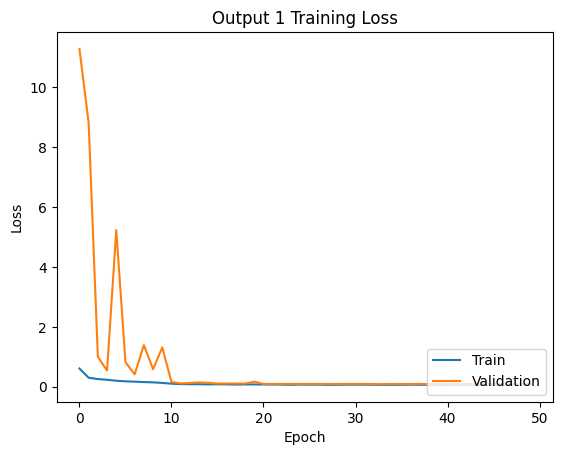

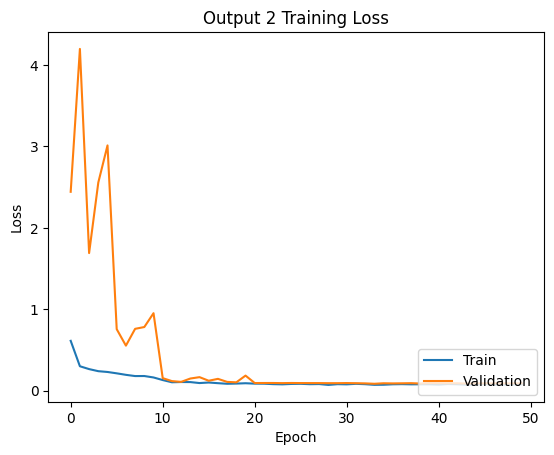

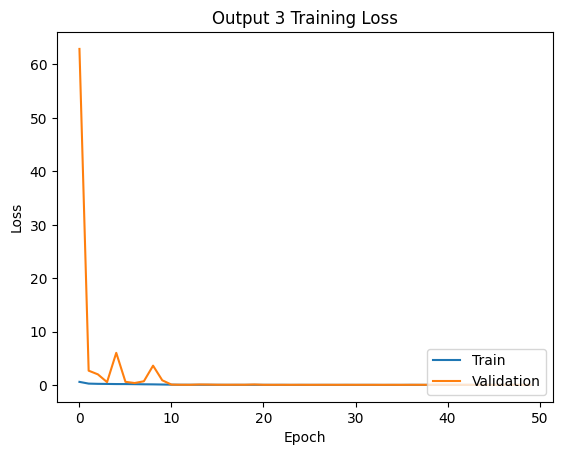

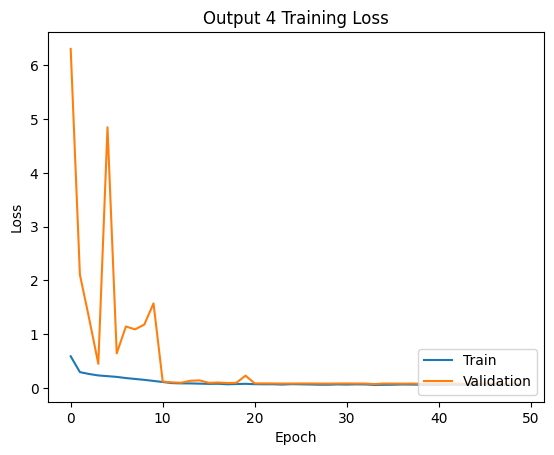

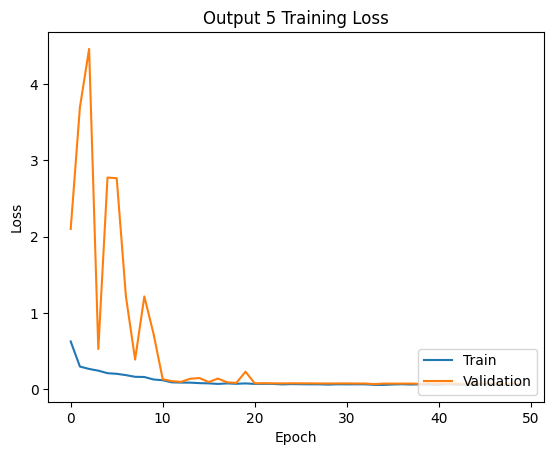

In [201]:
for i in range(1, 6):
    plt.plot(history.history['output_'+str(i)+'_loss'])
    plt.plot(history.history['val_output_'+str(i)+'_loss'])
    plt.title('Output '+str(i)+' Training Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.show()

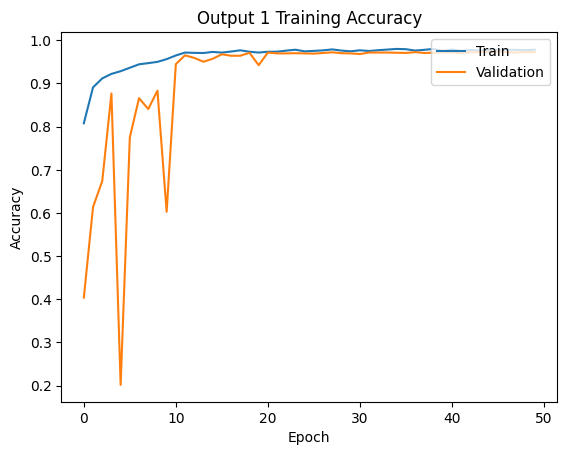

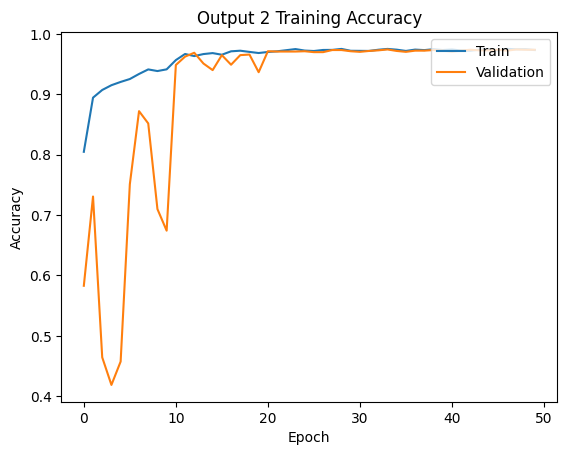

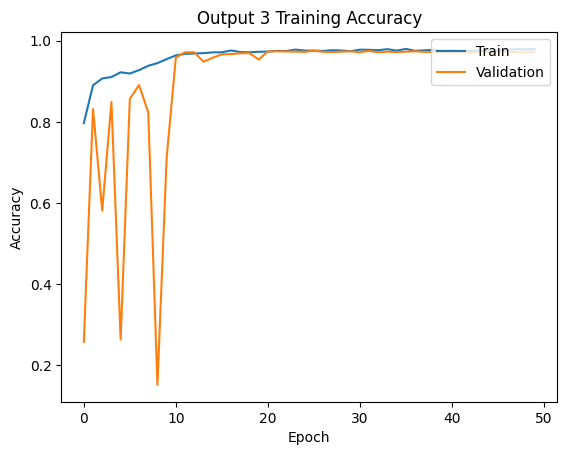

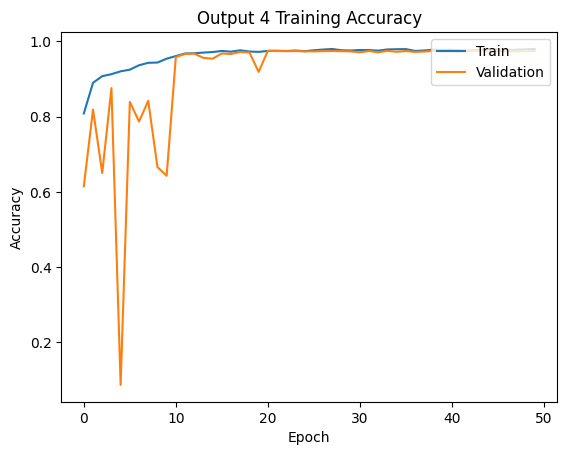

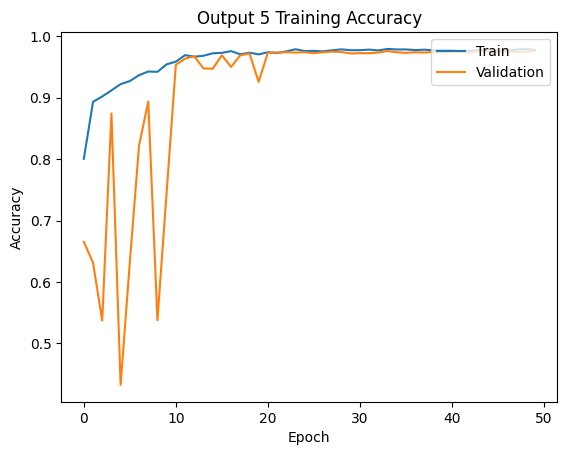

In [202]:
for i in range(1, 6):
    plt.plot(history.history['output_'+str(i)+'_accuracy'])
    plt.plot(history.history['val_output_'+str(i)+'_accuracy'])
    plt.title('Output '+str(i)+' Training Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

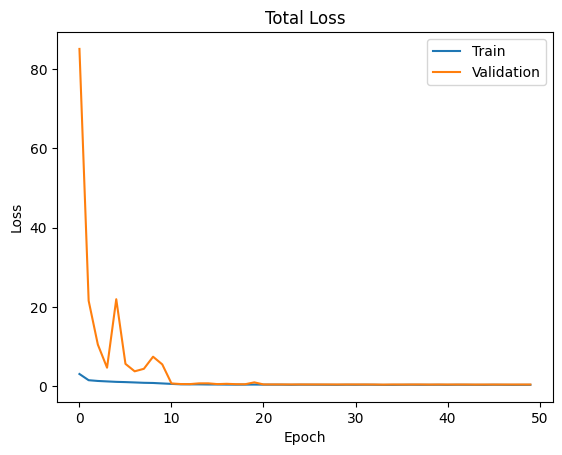

In [203]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Total Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

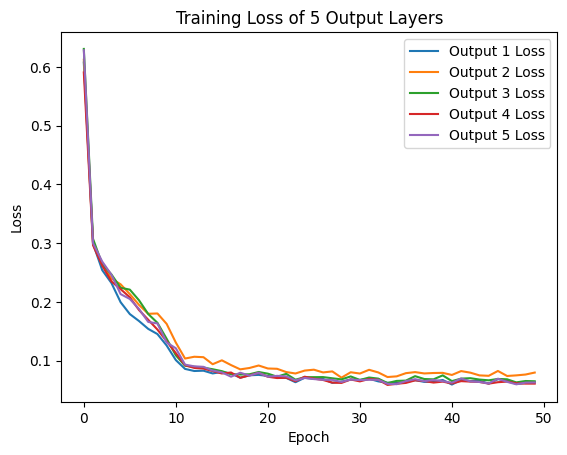

In [204]:
legends = []
for i in range(1, 6):
    plt.plot(history.history['output_'+str(i)+'_loss'])
    legends.append('Output '+str(i)+' Loss')
plt.title('Training Loss of 5 Output Layers')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(legends, loc='upper right')
plt.show()

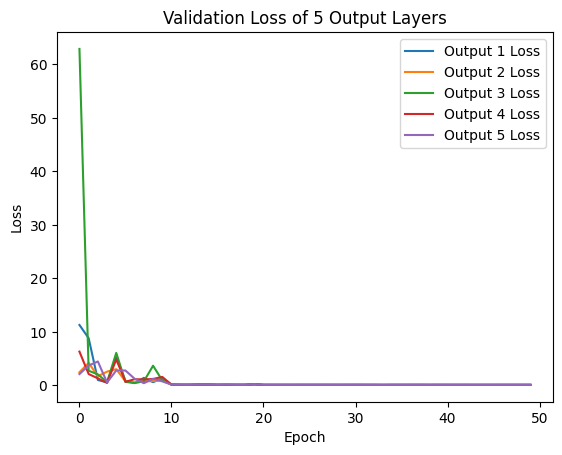

In [205]:
legends = []
for i in range(1, 6):
    plt.plot(history.history['val_output_'+str(i)+'_loss'])
    legends.append('Output '+str(i)+' Loss')
plt.title('Validation Loss of 5 Output Layers')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(legends, loc='upper right')
plt.show()

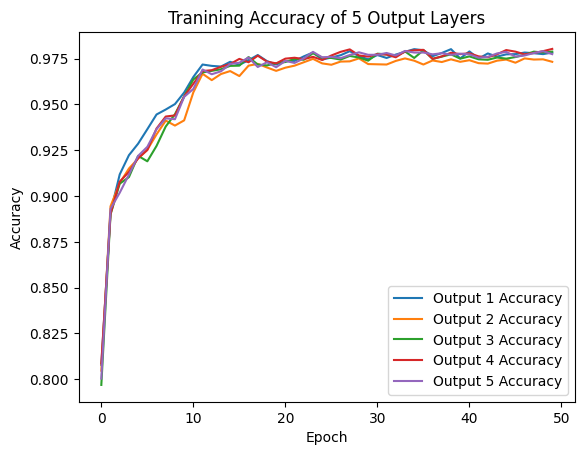

In [206]:
legends = []
for i in range(1, 6):
    plt.plot(history.history['output_'+str(i)+'_accuracy'])
    legends.append('Output '+str(i)+' Accuracy')
plt.title('Tranining Accuracy of 5 Output Layers')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(legends, loc='lower right')
plt.show()

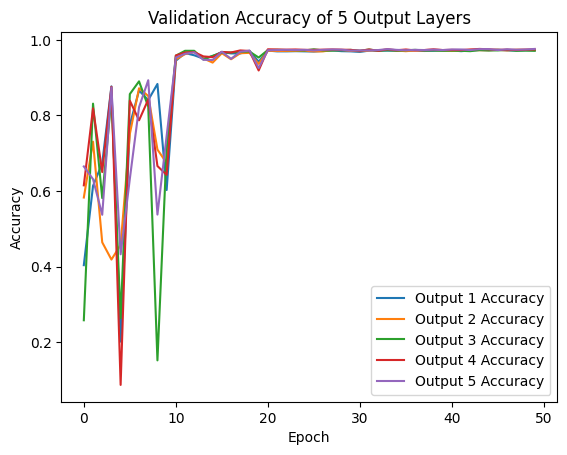

In [207]:
legends = []
for i in range(1, 6):
    plt.plot(history.history['val_output_'+str(i)+'_accuracy'])
    legends.append('Output '+str(i)+' Accuracy')
plt.title('Validation Accuracy of 5 Output Layers')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(legends, loc='lower right')
plt.show()

In [208]:
pred.shape

(5, 4339, 38)

In [209]:
for i in range(5):
    y_pred = np.argmax(pred[i, :, :], axis=-1)
    print("Accuracy score (Output layer "+str(i+1)+")  :", accuracy_score(y_true, y_pred))

Accuracy score (Output layer 1)  : 0.9596681262963817
Accuracy score (Output layer 2)  : 0.951601751555658
Accuracy score (Output layer 3)  : 0.9592071905969117
Accuracy score (Output layer 4)  : 0.9550587693016824
Accuracy score (Output layer 5)  : 0.9610509333947914


In [210]:
pred_avg = np.mean(pred, axis=0)
y_pred = np.argmax(pred_avg, axis=-1)
print("Accuracy score (Avreraged Predictions) :", accuracy_score(y_true, y_pred))

Accuracy score (Avreraged Predictions) : 0.9619728047937313


In [211]:
label_names = test_generator.class_indices.keys()
label_names

dict_keys(['Basophil', 'Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil'])

In [212]:
for i in range(5):
    y_pred = np.argmax(pred[i, :, :], axis=-1)
    print("Classification report for (Output layer "+str(i+1)+")  :")
    print(classification_report(y_true, y_pred, target_names=label_names))

Classification report for (Output layer 1)  :
              precision    recall  f1-score   support

    Basophil       0.98      1.00      0.99        89
  Eosinophil       0.80      0.98      0.88       322
  Lymphocyte       0.97      0.97      0.97      1034
    Monocyte       0.83      0.89      0.86       234
  Neutrophil       0.99      0.96      0.97      2660

    accuracy                           0.96      4339
   macro avg       0.91      0.96      0.93      4339
weighted avg       0.96      0.96      0.96      4339

Classification report for (Output layer 2)  :
              precision    recall  f1-score   support

    Basophil       0.99      1.00      0.99        89
  Eosinophil       0.70      0.97      0.81       322
  Lymphocyte       0.97      0.98      0.98      1034
    Monocyte       0.87      0.85      0.86       234
  Neutrophil       0.99      0.95      0.97      2660

    accuracy                           0.95      4339
   macro avg       0.91      0.95      

In [213]:
pred_avg = np.mean(pred, axis=0)
y_pred = np.argmax(pred_avg, axis=-1)
print("Classification report for (Averaged Prediction)")
print(classification_report(y_true, y_pred, target_names=label_names))

Classification report for (Averaged Prediction)
              precision    recall  f1-score   support

    Basophil       1.00      1.00      1.00        89
  Eosinophil       0.77      0.99      0.87       322
  Lymphocyte       0.98      0.98      0.98      1034
    Monocyte       0.89      0.89      0.89       234
  Neutrophil       0.99      0.96      0.97      2660

    accuracy                           0.96      4339
   macro avg       0.93      0.96      0.94      4339
weighted avg       0.97      0.96      0.96      4339

